# Embedding Methods for Spam Email Detection

We propose an e-mail spam filter which first embeds the e-mails in higher dimensional vector spaces then classifies them using machine learning methods. We test our filter on 'Spambase Dataset' available at [the UCI Machine Learning Repository](http://www.ics.uci.edu/~mlearn/MLRepository.html). For embedding the e-mails in higher dimensions, we use the vector representations of the words from the pretrained datasets by Word2Vec, GloVe, and FastText. For classification, we test with Logistic Regression (LogReg), Random Forest (RF), and Naive Bayes (NB) as well as some less transparent methods such as Support Vector Machines (SVM) and Multi-Layer Perceptor (MLP).

## Introduction
There are many publicly available benchmark spam datasets. In these datasets, the messages are usually kept as text like in the case of the below SMSSpamCollection

In [1]:
import numpy as np
import pandas as pd
import os
import io
import re
import glob 
import bcolz
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
data_sms=pd.read_csv('/mypath/smsspamcollection/SMSSpamCollection.txt',sep='\t',index_col=False,header=None,names=['Label','SMS'])
number_of_sms=data_sms.shape[0]
data_sms_nolabel=data_sms['SMS'] #SMS series
label=data_sms['Label'] #Label series
y=np.array([1 if label.iloc[i]=='spam' else 0 for i in range(number_of_sms)]) #convert the label to numeric (to be used later)
data_sms.head(2)

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


or sometimes to protect privacy they are encoded like in the case of PU corpora.

In [3]:
data_pu1=pd.DataFrame(index=range(1099),columns=['Subject','Space','Message','Label'])
for i,filename in enumerate(glob.glob('/mypath/pu_corpora_public/pu1/all_messages/*.txt')):
	with open(filename, 'r') as f:
		for cnt, line in enumerate(f):
			data_pu1.iloc[i][data_pu1.columns[cnt]]=line.replace('Subject:','').replace('\n','')
	if re.search('legit',filename):
		data_pu1.iloc[i]['Label'] =0
	else:
		data_pu1.iloc[i]['Label'] =1
data_pu1.drop('Space',inplace=True,axis=1)
label_pu1=data_pu1['Label']
subject_pu1=data_pu1['Subject']
message_pu1=data_pu1['Message']
data_pu1.head(2)

,Subject,Message,Label
0,2056 118 22577 20908 14616,284 14851 80 16147 17345 14338 130 19410 47 58...,0
1,2056 118 14140 84 13147 1613 383 80 1867 1601...,284 4353 47 17011 15691 9997 18783 1613 1613 9...,0


An important step in text processing is to find a numerical representation of the text. Among such methods, *Bag-of-Words* (BoW), *CountVectorizer*, and *Term frequency - Inverse document frequency* (Tf-idf) are the most common ones.

The main idea behind the methods like BoW, CountVec, and TfIdf is to count, in different ways, the occurences of the words or collection of words in the corpus. For instance, in the LINES below, we count only the words which are not in the 'english' dictionnary.

In [4]:
vect=TfidfVectorizer(stop_words='english',ngram_range=(1,1))# initiate
data_sms_vec=vect.fit_transform(data_sms_nolabel) #numeric sms

In [5]:
data_sms_vec.shape
features_vect=np.array(vect.get_feature_names())
data_sms_frame=pd.DataFrame(np.array(data_sms_vec.todense()),columns=features_vect)
data_sms_frame=data_sms_frame.join(pd.DataFrame({'Label':y}))
data_sms_frame.head(4)

,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,02,...,zindgi,zoe,zogtorius,zoom,zouk,zyada,èn,ú1,〨ud,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


This gives a numeric representation of the 5572 messages in terms of 8712 attributes determined by the default settings of the vectorizer TfidfVectorizer(). 

## Dataset
In this notebook, we work with the Spambase dataset. Our motivation is to test whether novel techniques in Natural Language Processing (NLP) such as *Word2Vec*, *GloVe*, and *FastText* can improve classifying e-mails where the corpus is not known. The e-mails are represented by the frequency information of the pre-selected 57 attributes and an  attribute for the class the e-mail (1=spam, 0=non_spam). Let us have a look:

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
#load the data as an array
data=np.genfromtxt('/mypath/spambase/spambase.txt',delimiter=',')
labels=data[:,-1]
data_nolabel=np.delete(data,57,axis=1)
#as as a dataframe a more presentable form
col_names=list(['make','address','all','3d','our','over','remove','internet','order','mail','receive','will','people','report','addresses','free','business','email','you','credit','your','font','000','money','hp','hpl','george','650','lab','labs','telnet','857','data','415','85','technology','1999','parts','pm','direct','cs','meeting','original','project','re','edu','table','conference',';','(','[','!','$','#','capital_run_length_average', 'capital_run_length_longes', 'capital_run_length_total','Label'])
data_df=pd.read_csv('/mypath/spambase/spambase.txt',index_col=False,names=col_names) 
data_df.head()

,make,address,all,3d,our,over,remove,internet,order,mail,...,;,(,[,!,$,#,capital_run_length_average,capital_run_length_longes,capital_run_length_total,Label
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


We separate 30% of the data for testing.

In [7]:
train_data,test_data,train_label,test_label=train_test_split(data_nolabel,labels,train_size=0.7,test_size=0.3,random_state=1654)

Any model that we build will be an achievement if its accuracy is greater than the null accuracy: 

In [8]:
null_model={'Non-Spam':1-test_label.mean(),'Spam':test_label.mean()}
print(null_model)

{'Non-Spam': 0.6046343229543809, 'Spam': 0.3953656770456191}


As this corpus is already in numerical form, we can train our first classifiers right away. We try 5 different types of classifiers: Logistic Regression, Linear Discriminant Analysis (LDA), Support Vector Machines (SVM), Boosted Tree, Random Forest, and Nearest Neighborhood. As our purpose is not the atteint the highest accuracy, we will not go into the parameter search and use all methods with their default settings in scikit-learn.   

In [9]:
# Logistic Regression (92.90%)
logreg=LogisticRegression(random_state=55973,solver='liblinear')
logreg.fit(train_data,train_label)
test_pred=logreg.predict(test_data)
print('Acc:',logreg.score(test_data,test_label))
tn, fp, fn, tp=confusion_matrix(test_label,test_pred).ravel()
print('TN:',tn,'FP:',fp,'FN:',fn,'TP:',tp)

Acc: 0.9290369297610427
TN: 793 FP: 42 FN: 56 TP: 490


In [10]:
# Random Forest (96.02%)
rf=RandomForestClassifier(random_state=55973,n_estimators=10)
rf.fit(train_data,train_label)
test_pred=rf.predict(test_data)
print('Acc:',rf.score(test_data,test_label))
tn, fp, fn, tp=confusion_matrix(test_label,test_pred).ravel()
print('TN:',tn,'FP:',fp,'FN:',fn,'TP:',tp)

Acc: 0.9601737871107893
TN: 817 FP: 18 FN: 37 TP: 509


In [11]:
# SVM (83.49%)
svm=SVC(random_state=55973,gamma='auto')
svm.fit(train_data,train_label)
test_pred=svm.predict(test_data)
print('Acc:',svm.score(test_data,test_label))
tn, fp, fn, tp=confusion_matrix(test_label,test_pred).ravel()
print('TN:',tn,'FP:',fp,'FN:',fn,'TP:',tp)

Acc: 0.834902244750181
TN: 704 FP: 131 FN: 97 TP: 449


In [12]:
# Decision Tree (91.67%)
tree=DecisionTreeClassifier(random_state=55973)
tree.fit(train_data,train_label)
test_pred=tree.predict(test_data)
print('Acc:',tree.score(test_data,test_label))
tn, fp, fn, tp=confusion_matrix(test_label,test_pred).ravel()
print('TN:',tn,'FP:',fp,'FN:',fn,'TP:',tp)

Acc: 0.9167270094134685
TN: 772 FP: 63 FN: 52 TP: 494


In [13]:
# LDA (89.57%)
lda=LinearDiscriminantAnalysis()
lda.fit(train_data,train_label)
test_pred=lda.predict(test_data)
print('Acc:',lda.score(test_data,test_label))
tn, fp, fn, tp=confusion_matrix(test_label,test_pred).ravel()
print('TN:',tn,'FP:',fp,'FN:',fn,'TP:',tp)

Acc: 0.8957277335264301
TN: 798 FP: 37 FN: 107 TP: 439


In [14]:
# KNN (79.51%)
knn=KNeighborsClassifier()
knn.fit(train_data,train_label)
test_pred=knn.predict(test_data)
print('Acc:',knn.score(test_data,test_label))
tn, fp, fn, tp=confusion_matrix(test_label,test_pred).ravel()
print('TN:',tn,'FP:',fp,'FN:',fn,'TP:',tp)

Acc: 0.7950760318609703
TN: 708 FP: 127 FN: 156 TP: 390


## Using Pretrained Methods
Using pretrained datasets for *Word2Vec*, *GloVe*, and *FastText*, we embed the Spambase dataset to a higher dimension.  First of all, from the pretrained dataset, we choose the $d$-dimensional attribute (column) vectors ${v_1, . . . , v_{57}}$ that represent the 57 attributes of the dataset. Next, we find a vector representation of the e-mails by doing a weighted summation of the attribute vectors with weights being the frequencies. That is, for all $i=1,\dots,4601$, $e_i =F(i,1)v_1 +...+F(i,n)v_n$ where $F=[F(i,j)]_{1\leq i \leq 4601,1\leq j \leq 57}$ is the dataset with labels(last column) removed. Finally, we arrange the vectors $e_i$ in the rows of the matrix $E = [e_1^T , \dots, e_m^T]$ of type $4601 \times d$. The matrix $E$ is the embedding of the e-mail corpus represented by the matrix $F$ to $d$ dimensions. Once the dataset is embedded into dimension $d$, we can train classifiers. One challenge that we might face during the above procedure is that some of the attributes might not have a corresponding vector in the used pretrained dataset. We will see how to handle these situations once we face them.

### Word2Vec Pretrained Dataset
We fisrt try Googlenews pretrained word2vec 300 dimensional vectors ([1]) to embed our the dataset.

In [15]:
#load word2vec
import gensim
from gensim.models import Word2Vec
w2v_words = gensim.models.KeyedVectors.load_word2vec_format(('/mypath/word2Vec/GoogleNews-vectors-negative300.bin'), binary=True)

Loaded vectors can be seen with the command.

In [ ]:
w2v_words['the']

We observe right away  that the words '000', 'hpl', '650', '857', '415', '85', '1999' do not have corresponding vectors. However all the characters in those missing words have. So we construct a vector for everyone of those missing words by adding the vectors that represent the characters in that word. For instance, for the word 'hpl', we add the vectors of the letters 'h', 'p', and 'l'.

In [16]:
word23_000=3*w2v_words['0']
word26_hpl=w2v_words['h']+w2v_words['p']+w2v_words['l']
word28_650=w2v_words['6']+w2v_words['5']+w2v_words['0']
word32_857=w2v_words['8']+w2v_words['5']+w2v_words['7']
word34_415=w2v_words['4']+w2v_words['1']+w2v_words['5']
word35_85=w2v_words['8']+w2v_words['5']
word37_1999=w2v_words['1']+w2v_words['9']+w2v_words['9']+w2v_words['9']+w2v_words['9']

The other problem that we run into is that the punctuation symbols ';','(','\[','!' as well as the 3 attributes 'capital_run_length_average', 'capital_run_length_longes', 'capital_run_length_total' do not have vector representation. For those, we simply concatanate their frequencies to the vectors. Hence, we obtain an embedding of the dataset into dimension 307.

In [17]:
email_words=np.column_stack([w2v_words['make'],w2v_words['address'],w2v_words['all'],w2v_words['3d'],w2v_words['our'],w2v_words['over'],w2v_words['remove'],w2v_words['internet'],w2v_words['order'],w2v_words['mail'],w2v_words['receive'],w2v_words['will'],w2v_words['people'],w2v_words['report'],w2v_words['addresses'],w2v_words['free'],w2v_words['business'],w2v_words['email'],w2v_words['you'],w2v_words['credit'],w2v_words['your'],w2v_words['font'],word23_000,w2v_words['money'],w2v_words['hp'],word26_hpl,w2v_words['george'],word28_650,w2v_words['lab'],w2v_words['labs'],w2v_words['telnet'],word32_857,w2v_words['data'],word34_415,word35_85,w2v_words['technology'],word37_1999,w2v_words['parts'],w2v_words['pm'],w2v_words['direct'],w2v_words['cs'],w2v_words['meeting'],w2v_words['original'],w2v_words['project'],w2v_words['re'],w2v_words['edu'],w2v_words['table'],w2v_words['conference'],w2v_words['$'],w2v_words['#']])
email_coef=np.delete(data_nolabel,[48,49,50,51,54,55,56],axis=1)
email_concat=np.delete(data_nolabel,np.append(np.arange(48),np.append(52,53)),axis=1)
email_body=np.zeros([4601,300])
for i in range(4601):
	for j in range(50):
		email_body[i,:]=email_body[i,:]+email_coef[i,j]*email_words[:,j]
emails=np.append(email_body,email_concat,axis=1)
print("the dataset is now of the form",emails.shape)

the dataset is now of the form (4601, 307)


We are ready to do classification.

In [18]:
w2v_train_data,w2v_test_data,w2v_train_label,w2v_test_label=train_test_split(emails,labels,train_size=0.7,test_size=0.3,random_state=1654)

In [19]:
# Logistic Regression (92.98%)
logreg_w2v=LogisticRegression(random_state=55973,solver='liblinear')
logreg_w2v.fit(w2v_train_data,w2v_train_label)
w2v_test_pred=logreg_w2v.predict(w2v_test_data)
print('Acc:',logreg_w2v.score(w2v_test_data,w2v_test_label))
tn, fp, fn, tp=confusion_matrix(w2v_test_label,w2v_test_pred).ravel()
print('TN:',tn,'FP:',fp,'FN:',fn,'TP:',tp)

Acc: 0.9297610427226647
TN: 792 FP: 43 FN: 54 TP: 492


In [20]:
# Random Forest (93.48%)
rf_w2v=RandomForestClassifier(random_state=55973,n_estimators=10)
rf_w2v.fit(w2v_train_data,w2v_train_label)
w2v_test_pred=rf_w2v.predict(w2v_test_data)
print('Acc:',rf_w2v.score(w2v_test_data,w2v_test_label))
tn, fp, fn, tp=confusion_matrix(w2v_test_label,w2v_test_pred).ravel()
print('TN:',tn,'FP:',fp,'FN:',fn,'TP:',tp)

Acc: 0.9348298334540188
TN: 798 FP: 37 FN: 53 TP: 493


In [21]:
# SVM (87.40%)
svm_w2v=SVC(random_state=55973,gamma='auto')
svm_w2v.fit(w2v_train_data,w2v_train_label)
w2v_test_pred=svm_w2v.predict(w2v_test_data)
print('Acc:',svm_w2v.score(w2v_test_data,w2v_test_label))
tn, fp, fn, tp=confusion_matrix(w2v_test_label,w2v_test_pred).ravel()
print('TN:',tn,'FP:',fp,'FN:',fn,'TP:',tp)

Acc: 0.8740043446777698
TN: 728 FP: 107 FN: 67 TP: 479


In [22]:
# Decision Tree (90.59%)
tree_w2v=DecisionTreeClassifier(random_state=55973)
tree_w2v.fit(w2v_train_data,w2v_train_label)
w2v_test_pred=tree_w2v.predict(w2v_test_data)
print('Acc:',tree_w2v.score(w2v_test_data,w2v_test_label))
tn, fp, fn, tp=confusion_matrix(w2v_test_label,w2v_test_pred).ravel()
print('TN:',tn,'FP:',fp,'FN:',fn,'TP:',tp)

Acc: 0.9058653149891384
TN: 761 FP: 74 FN: 56 TP: 490


In [23]:
# LDA (89.57%)
lda_w2v=LinearDiscriminantAnalysis()
lda_w2v.fit(w2v_train_data,w2v_train_label)
w2v_test_pred=lda_w2v.predict(w2v_test_data)
print('Acc:',lda_w2v.score(w2v_test_data,w2v_test_label))
tn, fp, fn, tp=confusion_matrix(w2v_test_label,w2v_test_pred).ravel()
print('TN:',tn,'FP:',fp,'FN:',fn,'TP:',tp)

Acc: 0.8957277335264301
TN: 798 FP: 37 FN: 107 TP: 439


/Users/emintatar/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


As the warning says the attributes are collinear. To remove colinearity, we apply PCA.

In [24]:
pca=PCA(n_components=307)
emails_pca=pca.fit_transform(emails)
w2v_train_data_pca,w2v_test_data_pca,w2v_train_label_pca,w2v_test_label_pca=train_test_split(emails_pca,labels,train_size=0.7,test_size=0.3,random_state=1654)

In [25]:
# LDA with PCA (89.71%)
lda_w2v_pca=LinearDiscriminantAnalysis()
lda_w2v_pca.fit(w2v_train_data_pca,w2v_train_label_pca)
w2v_pca_test_pred=lda_w2v_pca.predict(w2v_test_data_pca)
print('Acc:',lda_w2v_pca.score(w2v_test_data_pca,w2v_test_label_pca))
tn, fp, fn, tp=confusion_matrix(w2v_test_label_pca,w2v_pca_test_pred).ravel()
print('TN:',tn,'FP:',fp,'FN:',fn,'TP:',tp)

Acc: 0.8971759594496741
TN: 788 FP: 47 FN: 95 TP: 451


The collinearity is removed and the accuracy improves slightly.

In [26]:
# KNN (83.85%)
knn_w2v=KNeighborsClassifier()
knn_w2v.fit(w2v_train_data,w2v_train_label)
w2v_test_pred=knn_w2v.predict(w2v_test_data)
print('Acc:',knn_w2v.score(w2v_test_data,w2v_test_label))
tn, fp, fn, tp=confusion_matrix(w2v_test_label,w2v_test_pred).ravel()
print('TN:',tn,'FP:',fp,'FN:',fn,'TP:',tp)

Acc: 0.8385228095582911
TN: 719 FP: 116 FN: 107 TP: 439


### GloVe Pretrained Dataset
Let's try the same approch with 1.9 million 300-dimensional word vectors trained by GloVe on Common Crawl dataset.[2]

In [27]:
#loading Glove pretrained 
words = []
idx = 0
word2idx = {}
vectors = bcolz.carray(np.zeros(1), rootdir='/mypath/Glove/yukleme', mode='w')
with open('/mypath/Glove/glove.6B.300d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)
    
vectors = bcolz.carray(vectors[1:].reshape((400000,300)), rootdir='/mypath/Glove/yukleme', mode='w')
vectors.flush()
pickle.dump(words, open('/mypath/Glove/glove.6B.300d.txt_words.pkl', 'wb'))
pickle.dump(word2idx, open('/mypath/Glove/glove.6B.300d.txt_idx.pkl', 'wb'))

glove_words = {w: vectors[word2idx[w]] for w in words} # creates the dictionary with the word and its associated vector

We can see the loaded vectors with the command.

In [ ]:
glove_words['the']

In this pretrained dataset, all the attributes except the 3 that correpond to the capital runs have vector representation. So by concatanating these 3 attributes to the pretrained vectors, we obtain an embedding of the e-mail dataset into dimension 303.

In [28]:
words_in_glove=['make','address','all','3d','our','over','remove','internet','order','mail','receive','will','people','report','addresses','free','business','email','you','credit','your','font','000','money','hp','hpl','george','650','lab','labs','telnet','857','data','415','85','technology','1999','parts','pm','direct','cs','meeting','original','project','re','edu','table','conference',';','(','[','!','$','#']
email_glove_words=np.column_stack([glove_words['make'],glove_words['address'],glove_words['all'],glove_words['3d'],glove_words['our'],glove_words['over'],glove_words['remove'],glove_words['internet'],glove_words['order'],glove_words['mail'],glove_words['receive'],glove_words['will'],glove_words['people'],glove_words['report'],glove_words['addresses'],glove_words['free'],glove_words['business'],glove_words['email'],glove_words['you'],glove_words['credit'],glove_words['your'],glove_words['font'],glove_words['000'],glove_words['money'],glove_words['hp'],glove_words['hpl'],glove_words['george'],glove_words['650'],glove_words['lab'],glove_words['labs'],glove_words['telnet'],glove_words['857'],glove_words['data'],glove_words['415'],glove_words['85'],glove_words['technology'],glove_words['1999'],glove_words['parts'],glove_words['pm'],glove_words['direct'],glove_words['cs'],glove_words['meeting'],glove_words['original'],glove_words['project'],glove_words['re'],glove_words['edu'],glove_words['table'],glove_words['conference'],glove_words[';'],glove_words['('],glove_words['['],glove_words['!'],glove_words['$'],glove_words['#']])
email_glove_coef=np.delete(data_nolabel,[54,55,56],axis=1)
email_glove_concat=np.delete(data_nolabel,np.arange(54),axis=1)
email_glove_body=np.zeros([4601,300])
for i in range(4601):
	for j in range(len(words_in_glove)):
		email_glove_body[i,:]=email_glove_body[i,:]+email_glove_coef[i,j]*email_glove_words[:,j]
glove_emails=np.append(email_glove_body,email_glove_concat,axis=1)
print("the dataset is now of the form",glove_emails.shape)

the dataset is now of the form (4601, 303)


In [29]:
glove_train_data,glove_test_data,glove_train_label,glove_test_label=train_test_split(glove_emails,labels,train_size=0.7,test_size=0.3,random_state=1654)

In [30]:
# Logistic Regression (93.05%)
logreg_glove=LogisticRegression(random_state=55973,solver='liblinear')
logreg_glove.fit(glove_train_data,glove_train_label)
glove_test_pred=logreg_glove.predict(glove_test_data)
print('Acc:',logreg_glove.score(glove_test_data,glove_test_label))
tn, fp, fn, tp=confusion_matrix(glove_test_label,glove_test_pred).ravel()
print('TN:',tn,'FP:',fp,'FN:',fn,'TP:',tp)

Acc: 0.9304851556842868
TN: 792 FP: 43 FN: 53 TP: 493


In [31]:
# Random Forest (93.05%)
rf_glove=RandomForestClassifier(random_state=55973,n_estimators=10)
rf_glove.fit(glove_train_data,glove_train_label)
glove_test_pred=rf_glove.predict(glove_test_data)
print('Acc:',rf_glove.score(glove_test_data,glove_test_label))
tn, fp, fn, tp=confusion_matrix(glove_test_label,glove_test_pred).ravel()
print('TN:',tn,'FP:',fp,'FN:',fn,'TP:',tp)

Acc: 0.9304851556842868
TN: 804 FP: 31 FN: 65 TP: 481


In [32]:
# SVM (86.89%)
svm_glove=SVC(random_state=55973,gamma='auto')
svm_glove.fit(glove_train_data,glove_train_label)
glove_test_pred=svm_glove.predict(glove_test_data)
print('Acc:',svm_glove.score(glove_test_data,glove_test_label))
tn, fp, fn, tp=confusion_matrix(glove_test_label,glove_test_pred).ravel()
print('TN:',tn,'FP:',fp,'FN:',fn,'TP:',tp)

Acc: 0.8689355539464156
TN: 794 FP: 41 FN: 140 TP: 406


In [33]:
# Decision Tree (90.59%)
tree_glove=DecisionTreeClassifier(random_state=55973)
tree_glove.fit(glove_train_data,glove_train_label)
glove_test_pred=tree_glove.predict(glove_test_data)
print('Acc:',tree_glove.score(glove_test_data,glove_test_label))
tn, fp, fn, tp=confusion_matrix(glove_test_label,glove_test_pred).ravel()
print('TN:',tn,'FP:',fp,'FN:',fn,'TP:',tp)

Acc: 0.9058653149891384
TN: 762 FP: 73 FN: 57 TP: 489


In [34]:
# LDA (89.57%)
lda_glove=LinearDiscriminantAnalysis()
lda_glove.fit(glove_train_data,glove_train_label)
glove_test_pred=lda_glove.predict(glove_test_data)
print('Acc:',lda_glove.score(glove_test_data,glove_test_label))
tn, fp, fn, tp=confusion_matrix(glove_test_label,glove_test_pred).ravel()
print('TN:',tn,'FP:',fp,'FN:',fn,'TP:',tp)

Acc: 0.8957277335264301
TN: 798 FP: 37 FN: 107 TP: 439


/Users/emintatar/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


To remove collinearity, we apply again PCA.

In [35]:
pca=PCA(n_components=303)
glove_emails_pca=pca.fit_transform(glove_emails)
glove_train_data_pca,glove_test_data_pca,glove_train_label_pca,glove_test_label_pca=train_test_split(glove_emails_pca,labels,train_size=0.7,test_size=0.3,random_state=1654)

In [36]:
# LDA with PCA (90.51%)
lda_glove_pca=LinearDiscriminantAnalysis()
lda_glove_pca.fit(glove_train_data_pca,glove_train_label_pca)
glove_pca_test_pred=lda_glove_pca.predict(glove_test_data_pca)
print('Acc:',lda_glove_pca.score(glove_test_data_pca,glove_test_label_pca))
tn, fp, fn, tp=confusion_matrix(glove_test_label_pca,glove_pca_test_pred).ravel()
print('TN:',tn,'FP:',fp,'FN:',fn,'TP:',tp)

Acc: 0.9051412020275162
TN: 796 FP: 39 FN: 92 TP: 454


In [37]:
# KNN (87.91%)
knn_glove=KNeighborsClassifier()
knn_glove.fit(glove_train_data,glove_train_label)
glove_test_pred=knn_glove.predict(glove_test_data)
print('Acc:',knn_glove.score(glove_test_data,glove_test_label))
tn, fp, fn, tp=confusion_matrix(glove_test_label,glove_test_pred).ravel()
print('TN:',tn,'FP:',fp,'FN:',fn,'TP:',tp)

Acc: 0.8790731354091238
TN: 744 FP: 91 FN: 76 TP: 470


### FastText Pretrained Dataset
Finally, we repeat the same procedure one last time with 2 million 300-dimensional word vectors trained by FastText on Common Crawl dataset [3].

In [38]:
#loading FastText pretrained 
words = []
idx = 0
word2idx = {}
vectors = bcolz.carray(np.zeros(1), rootdir='/mypath/FastText/yukleme', mode='w')
with open('/mypath/FastText/crawl-300d-2M.vec', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)
    
vectors = bcolz.carray(vectors[2:].reshape((1999995,300)), rootdir='/mypath/FastText/yukleme', mode='w')
vectors.flush()
pickle.dump(words, open('/mypath/FastText/crawl-300d-2M.vec_words.pkl', 'wb'))
pickle.dump(word2idx, open('/mypath/FastText/crawl-300d-2M.vec_idx.pkl', 'wb'))


fasttext_words = {w: vectors[word2idx[w]-1] for w in words[1:]}

We can see the loaded vectors with the command.

In [ ]:
fasttext_words['the'] 

Like in the case of dataset trained by GloVe, all atributes except the 3 about capital run have vector presentation. 

In [39]:
email_fasttext_words=np.column_stack([fasttext_words['make'],fasttext_words['address'],fasttext_words['all'],fasttext_words['3d'],fasttext_words['our'],fasttext_words['over'],fasttext_words['remove'],fasttext_words['internet'],fasttext_words['order'],fasttext_words['mail'],fasttext_words['receive'],fasttext_words['will'],fasttext_words['people'],fasttext_words['report'],fasttext_words['addresses'],fasttext_words['free'],fasttext_words['business'],fasttext_words['email'],fasttext_words['you'],fasttext_words['credit'],fasttext_words['your'],fasttext_words['font'],fasttext_words['000'],fasttext_words['money'],fasttext_words['hp'],fasttext_words['hpl'],fasttext_words['george'],fasttext_words['650'],fasttext_words['lab'],fasttext_words['labs'],fasttext_words['telnet'],fasttext_words['857'],fasttext_words['data'],fasttext_words['415'],fasttext_words['85'],fasttext_words['technology'],fasttext_words['1999'],fasttext_words['parts'],fasttext_words['pm'],fasttext_words['direct'],fasttext_words['cs'],fasttext_words['meeting'],fasttext_words['original'],fasttext_words['project'],fasttext_words['re'],fasttext_words['edu'],fasttext_words['table'],fasttext_words['conference'],fasttext_words[';'],fasttext_words['('],fasttext_words['['],fasttext_words['!'],fasttext_words['$'],fasttext_words['#']])
words_in_fasttext=['make','address','all','3d','our','over','remove','internet','order','mail','receive','will','people','report','addresses','free','business','email','you','credit','your','font','000','money','hp','hpl','george','650','lab','labs','telnet','857','data','415','85','technology','1999','parts','pm','direct','cs','meeting','original','project','re','edu','table','conference',';','(','[','!','$','#']

email_fasttext_coef=np.delete(data_nolabel,[54,55,56],axis=1)
email_fasttext_concat=np.delete(data_nolabel,np.arange(54),axis=1)
email_fasttext_body=np.zeros([4601,300])
for i in range(4601):
	for j in range(len(words_in_fasttext)):
		email_fasttext_body[i,:]=email_fasttext_body[i,:]+email_fasttext_coef[i,j]*email_fasttext_words[:,j]

fasttext_emails=np.append(email_fasttext_body,email_fasttext_concat,axis=1)
print("the dataset is now of the form",fasttext_emails.shape)

the dataset is now of the form (4601, 303)


In [40]:
fasttext_train_data,fasttext_test_data,fasttext_train_label,fasttext_test_label=train_test_split(fasttext_emails,labels,train_size=0.7,test_size=0.3,random_state=1654)

In [41]:
# Logistic Regression (93.19%)
logreg_fasttext=LogisticRegression(random_state=55973,solver='liblinear')
logreg_fasttext.fit(fasttext_train_data,fasttext_train_label)
fasttext_test_pred=logreg_fasttext.predict(fasttext_test_data)
print('Acc:',logreg_fasttext.score(fasttext_test_data,fasttext_test_label))
tn, fp, fn, tp=confusion_matrix(fasttext_test_label,fasttext_test_pred).ravel()
print('TN:',tn,'FP:',fp,'FN:',fn,'TP:',tp)

Acc: 0.9319333816075308
TN: 793 FP: 42 FN: 52 TP: 494


In [43]:
# Random Forest (94.64%)
rf_fasttext=RandomForestClassifier(random_state=55973,n_estimators=10)
rf_fasttext.fit(fasttext_train_data,fasttext_train_label)
fasttext_test_pred=rf_fasttext.predict(fasttext_test_data)
print('Acc:',rf_fasttext.score(fasttext_test_data,fasttext_test_label))
tn, fp, fn, tp=confusion_matrix(fasttext_test_label,fasttext_test_pred).ravel()
print('TN:',tn,'FP:',fp,'FN:',fn,'TP:',tp)

Acc: 0.946415640839971
TN: 809 FP: 26 FN: 48 TP: 498


In [44]:
# SVM (88.92%)
svm_fasttext=SVC(random_state=55973,gamma='auto')
svm_fasttext.fit(fasttext_train_data,fasttext_train_label)
fasttext_test_pred=svm_fasttext.predict(fasttext_test_data)
print('Acc:',svm_fasttext.score(fasttext_test_data,fasttext_test_label))
tn, fp, fn, tp=confusion_matrix(fasttext_test_label,fasttext_test_pred).ravel()
print('TN:',tn,'FP:',fp,'FN:',fn,'TP:',tp)

Acc: 0.889210716871832
TN: 744 FP: 91 FN: 62 TP: 484


In [45]:
# Decision Tree (90.88%)
tree_fasttext=DecisionTreeClassifier(random_state=55973)
tree_fasttext.fit(fasttext_train_data,fasttext_train_label)
fasttext_test_pred=tree_fasttext.predict(fasttext_test_data)
print('Acc:',tree_fasttext.score(fasttext_test_data,fasttext_test_label))
tn, fp, fn, tp=confusion_matrix(fasttext_test_label,fasttext_test_pred).ravel()
print('TN:',tn,'FP:',fp,'FN:',fn,'TP:',tp)

Acc: 0.9087617668356264
TN: 766 FP: 69 FN: 57 TP: 489


In [46]:
# LDA (89.57%)
lda_fasttext=LinearDiscriminantAnalysis()
lda_fasttext.fit(fasttext_train_data,fasttext_train_label)
fasttext_test_pred=lda_fasttext.predict(fasttext_test_data)
print('Acc:',lda_fasttext.score(fasttext_test_data,fasttext_test_label))
tn, fp, fn, tp=confusion_matrix(fasttext_test_label,fasttext_test_pred).ravel()
print('TN:',tn,'FP:',fp,'FN:',fn,'TP:',tp)

Acc: 0.8957277335264301
TN: 798 FP: 37 FN: 107 TP: 439


/Users/emintatar/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Apply PCA to remove collinearity.

In [47]:
pca=PCA(n_components=303)
fasttext_emails_pca=pca.fit_transform(fasttext_emails)
fasttext_train_data_pca,fasttext_test_data_pca,fasttext_train_label_pca,fasttext_test_label_pca=train_test_split(fasttext_emails_pca,labels,train_size=0.7,test_size=0.3,random_state=1654)

In [48]:
# LDA with PCA (90%)
lda_fasttext_pca=LinearDiscriminantAnalysis()
lda_fasttext_pca.fit(fasttext_train_data_pca,fasttext_train_label_pca)
fasttext_pca_test_pred=lda_fasttext_pca.predict(fasttext_test_data_pca)
print('Acc:',lda_fasttext_pca.score(fasttext_test_data_pca,fasttext_test_label_pca))
tn, fp, fn, tp=confusion_matrix(fasttext_test_label_pca,fasttext_pca_test_pred).ravel()
print('TN:',tn,'FP:',fp,'FN:',fn,'TP:',tp)

Acc: 0.9000724112961622
TN: 799 FP: 36 FN: 102 TP: 444


In [49]:
# KNN (85.16%)
knn_fasttext=KNeighborsClassifier()
knn_fasttext.fit(fasttext_train_data,fasttext_train_label)
fasttext_test_pred=knn_fasttext.predict(fasttext_test_data)
print('Acc:',knn_fasttext.score(fasttext_test_data,fasttext_test_label))
tn, fp, fn, tp=confusion_matrix(fasttext_test_label,fasttext_test_pred).ravel()
print('TN:',tn,'FP:',fp,'FN:',fn,'TP:',tp)

Acc: 0.8515568428674873
TN: 723 FP: 112 FN: 93 TP: 453


## Conclusion

In [90]:
results=pd.DataFrame({'Classifier':['LogReg','RandForest','SVM','D.Tree','PCA+LDA','KNN'],'Original':[logreg.score(test_data,test_label),rf.score(test_data,test_label),svm.score(test_data,test_label),tree.score(test_data,test_label),lda.score(test_data,test_label),knn.score(test_data,test_label)],'Word2Vec':[logreg_w2v.score(w2v_test_data,w2v_test_label),rf_w2v.score(w2v_test_data,w2v_test_label),svm_w2v.score(w2v_test_data,w2v_test_label),tree_w2v.score(w2v_test_data,w2v_test_label),lda_w2v_pca.score(w2v_test_data_pca,w2v_test_label_pca),knn_w2v.score(w2v_test_data,w2v_test_label)],'Glove':[logreg_glove.score(glove_test_data,glove_test_label),rf_glove.score(glove_test_data,glove_test_label),svm_glove.score(glove_test_data,glove_test_label),tree_glove.score(glove_test_data,glove_test_label),lda_glove_pca.score(glove_test_data_pca,glove_test_label_pca),knn_glove.score(glove_test_data,glove_test_label)],'FastText':[logreg_fasttext.score(fasttext_test_data,fasttext_test_label),rf_fasttext.score(fasttext_test_data,fasttext_test_label),svm_fasttext.score(fasttext_test_data,fasttext_test_label),tree_fasttext.score(fasttext_test_data,fasttext_test_label),lda_fasttext_pca.score(fasttext_test_data_pca,fasttext_test_label_pca),knn_fasttext.score(fasttext_test_data,fasttext_test_label)]})

In [91]:
results

,Classifier,Original,Word2Vec,Glove,FastText
0,LogReg,0.929037,0.929761,0.930485,0.931933
1,RandForest,0.960174,0.934830,0.930485,0.946416
2,SVM,0.834902,0.874004,0.868936,0.889211
3,D.Tree,0.916727,0.905865,0.905865,0.908762
4,PCA+LDA,0.895728,0.897176,0.905141,0.900072
5,KNN,0.795076,0.838523,0.879073,0.851557


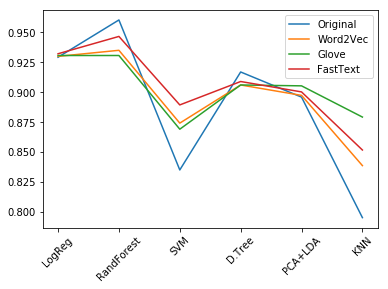

In [92]:
fig,ax=plt.subplots()
results.plot(ax=ax,xticks=results.index,rot=45)
ax.set_xticklabels(results['Classifier'])
plt.show()

We observe that embedding the dataset into higher dimensions gives slight advantage when linear classifiers are used and significant advantage when KNeighborhood classifier is used. On the other hand, the original form of the dataset clearly performs better when tree-based classifiers are used, something tht will be investigated in the further posts.

### Refenrences
1) Tomas Mikolov, Kai Chen, Greg Corrado, and Jeffrey Dean. Efficient estimation of word representations in vector space. arXiv preprint arXiv:1301.3781, 2013.

2) Jeffrey Pennington, Richard Socher, and Christopher D. Manning. Glove: Global vectors for word representation. In Empirical Methods in Natural Language Processing (EMNLP), pages 1532–1543, 2014.

3) Armand Joulin, Edouard Grave, Piotr Bojanowski, and Tomas Mikolov. Bag of tricks for efficient text classification. arXiv preprint arXiv:1607.01759, 2016.